## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-16 16:07:46.928 | INFO     |  Running on cuda:0


In [3]:
task = 'Banana'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-16 16:07:47.875 | INFO     |  Loading dataset(s): 
2024-08-16 16:07:47.876 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Banana/demos/metadata.json
2024-08-16 16:07:47.885 | INFO     |    Extracted gt object labels []
2024-08-16 16:07:47.885 | INFO     |    Extracted tsdf object labels []
2024-08-16 16:07:47.886 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}

In [5]:
observations = scene_data.get_demos(**kp_config, indeces=list(range(4)))

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    kp_indeces=None,  # list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-16 16:07:49.736 | INFO     |  Subsampling to length 297 using strategy mean-length.


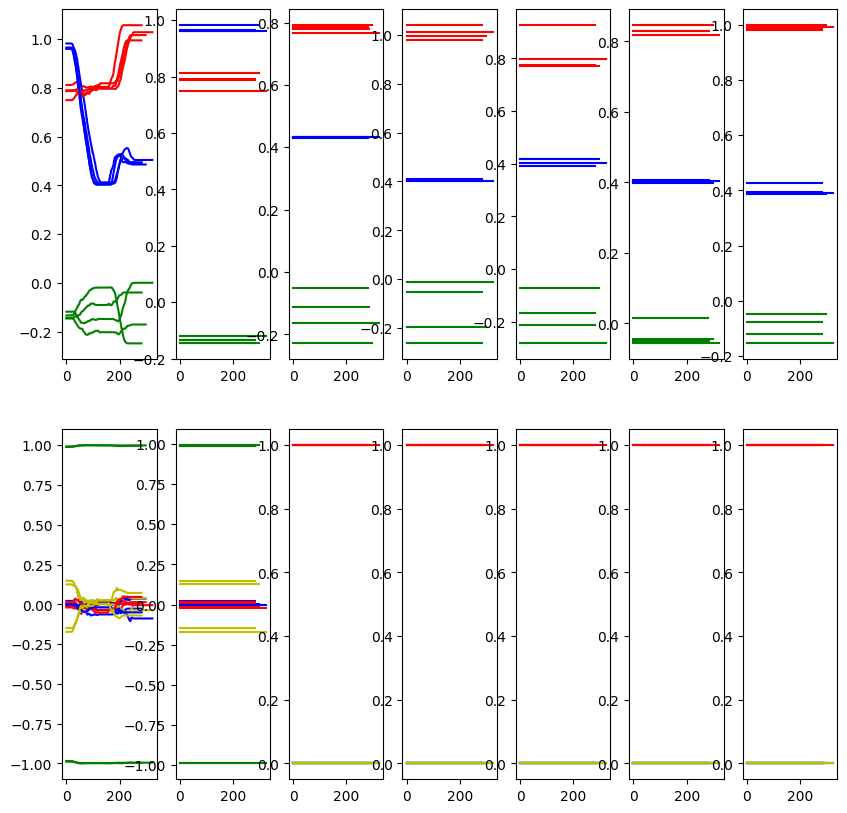

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=True,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.8,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=4,

    velocity_threshold=0.002,
    max_idx_distance=1,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-16 16:07:50.651 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:07:50.652 | INFO     |  Performing fitting actions: [INIT]
2024-08-16 16:07:50.652 | INFO     |  Segmenting trajectories


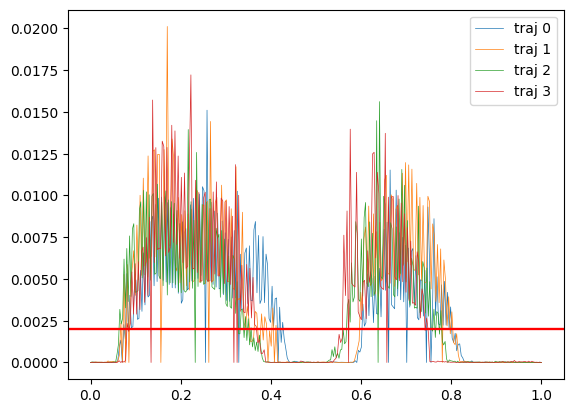

2024-08-16 16:07:50.763 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(287, dtype=torch.int32),) from traj 2 of len 324
2024-08-16 16:07:50.764 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(247, dtype=torch.int32),) from traj 3 of len 284
2024-08-16 16:07:50.764 | INFO     |  Creating segement of demos.
2024-08-16 16:07:50.765 | INFO     |  Subsampling to length 143 using strategy mean-length.
2024-08-16 16:07:50.765 | INFO     |  Creating segement of demos.
2024-08-16 16:07:50.767 | INFO     |  Subsampling to length 153 using strategy mean-length.
2024-08-16 16:07:50.767 | INFO     |  ... created 2 segments
2024-08-16 16:07:50.767 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:07:50.767 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:07:50.769 | WARNING  |    Rie

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:50.780 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:07:50.780 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:50.804 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:07:50.805 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:50.822 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:07:50.823 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:50.844 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:07:50.844 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:50.879 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:07:50.880 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:50.916 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-16 16:07:50.916 | INFO     |  kp 0       score (rel):     -1 (0.934)
2024-08-16 16:07:50.916 | INFO     |  kp 1       score (rel):     -0 (0.003)
2024-08-16 16:07:50.916 | INFO     |  kp 2       score (rel):     -0 (0.002)
2024-08-16 16:07:50.916 | INFO     |  kp 3       score (rel):     -0 (0.438)
2024-08-16 16:07:50.916 | INFO     |  kp 4       score (rel):     -0 (0.135)
2024-08-16 16:07:50.917 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:07:50.993 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:07:50.993 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.016 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:07:51.017 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.055 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:07:51.055 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.097 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:07:51.097 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.147 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:07:51.147 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.187 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:07:51.187 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.282 | INFO     |  ee_init    score (rel):     -0 (0.251)
2024-08-16 16:07:51.282 | INFO     |  kp 0       score (rel):     -1 (0.937)
2024-08-16 16:07:51.282 | INFO     |  kp 1       score (rel):     -1 (1.000)
2024-08-16 16:07:51.282 | INFO     |  kp 2       score (rel):     -0 (0.064)
2024-08-16 16:07:51.282 | INFO     |  kp 3       score (rel):     -0 (0.288)
2024-08-16 16:07:51.282 | INFO     |  kp 4       score (rel):     -0 (0.050)
2024-08-16 16:07:51.283 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:07:51.285 | INFO     |  Segmented trajs into 2 segments
2024-08-16 16:07:51.287 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.990927 -0.925810 -0.002523 -0.001627 -0.433822 -0.133456
Segment 1 -0.249204 -0.929326 -0.991647 -0.063831 -0.285464 -0.049880
2024-08-16 16:07:51.289 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:07:51.299 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[1.64e+010, 2.18e+010, 2.77e+010, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [8.37e+003, 3.81e+004, 1.61e+005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [7.09e-012, 1.65e-010, 3.43e-009, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [6.89e-234, 1.02e-233, 1.34e-233, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.24e+009, 8.83e+008,
          5.69e+008]]),
  array([[7.07e+09, 9.30e+09, 1.18e+10, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.09e+04, 2.31e+05, 6.30e+05, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.26e-27, 5.23e-25, 7.09e-23, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.47e-09, 7.59e-10, 8.40e-11],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.10e+06, 4.33e+05, 1.63e+05],
         [0.00e+00, 0.00e+00, 0.00e+00

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-16 16:07:51.412 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:07:51.413 | INFO     |  Segmenting trajectories


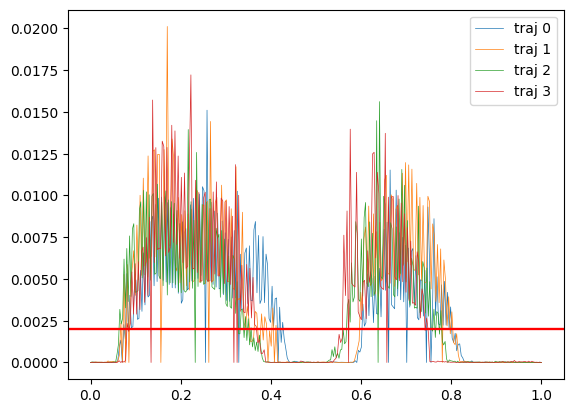

2024-08-16 16:07:51.528 | INFO     |  Creating segement of demos.
2024-08-16 16:07:51.530 | INFO     |  Creating segement of demos.
2024-08-16 16:07:51.534 | INFO     |  ... created 2 segments
2024-08-16 16:07:51.534 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:07:51.535 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.561 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:07:51.562 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.590 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:07:51.591 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.614 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:07:51.615 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.630 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:07:51.630 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.648 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:07:51.649 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.663 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:07:51.740 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:07:51.740 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.781 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:07:51.782 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.828 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:07:51.829 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.853 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:07:51.853 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.879 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:07:51.880 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.906 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:07:51.906 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:07:51.932 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:07:51.935 | INFO     |  Segmented trajs into 2 segments
2024-08-16 16:07:51.937 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.990927 -0.925810 -0.002523 -0.001627 -0.433822 -0.133456
Segment 1 -0.249204 -0.929326 -0.991647 -0.063831 -0.285464 -0.049880
2024-08-16 16:07:51.938 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0  1.000000  0.934287  0.002547  0.001642  0.437794  0.134678
Segment 1  0.251303  0.937154  1.000000  0.064369  0.287869  0.050300


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[1.64e+010, 2.18e+010, 2.77e+010, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [8.37e+003, 3.81e+004, 1.61e+005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [7.09e-012, 1.65e-010, 3.43e-009, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [6.89e-234, 1.02e-233, 1.34e-233, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.24e+009, 8.83e+008,
          5.69e+008]]),
  array([[7.07e+09, 9.30e+09, 1.18e+10, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.09e+04, 2.31e+05, 6.30e+05, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.26e-27, 5.23e-25, 7.09e-23, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.47e-09, 7.59e-10, 8.40e-11],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.10e+06, 4.33e+05, 1.63e+05],
         [0.00e+00, 0.00e+00, 0.00e+00

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


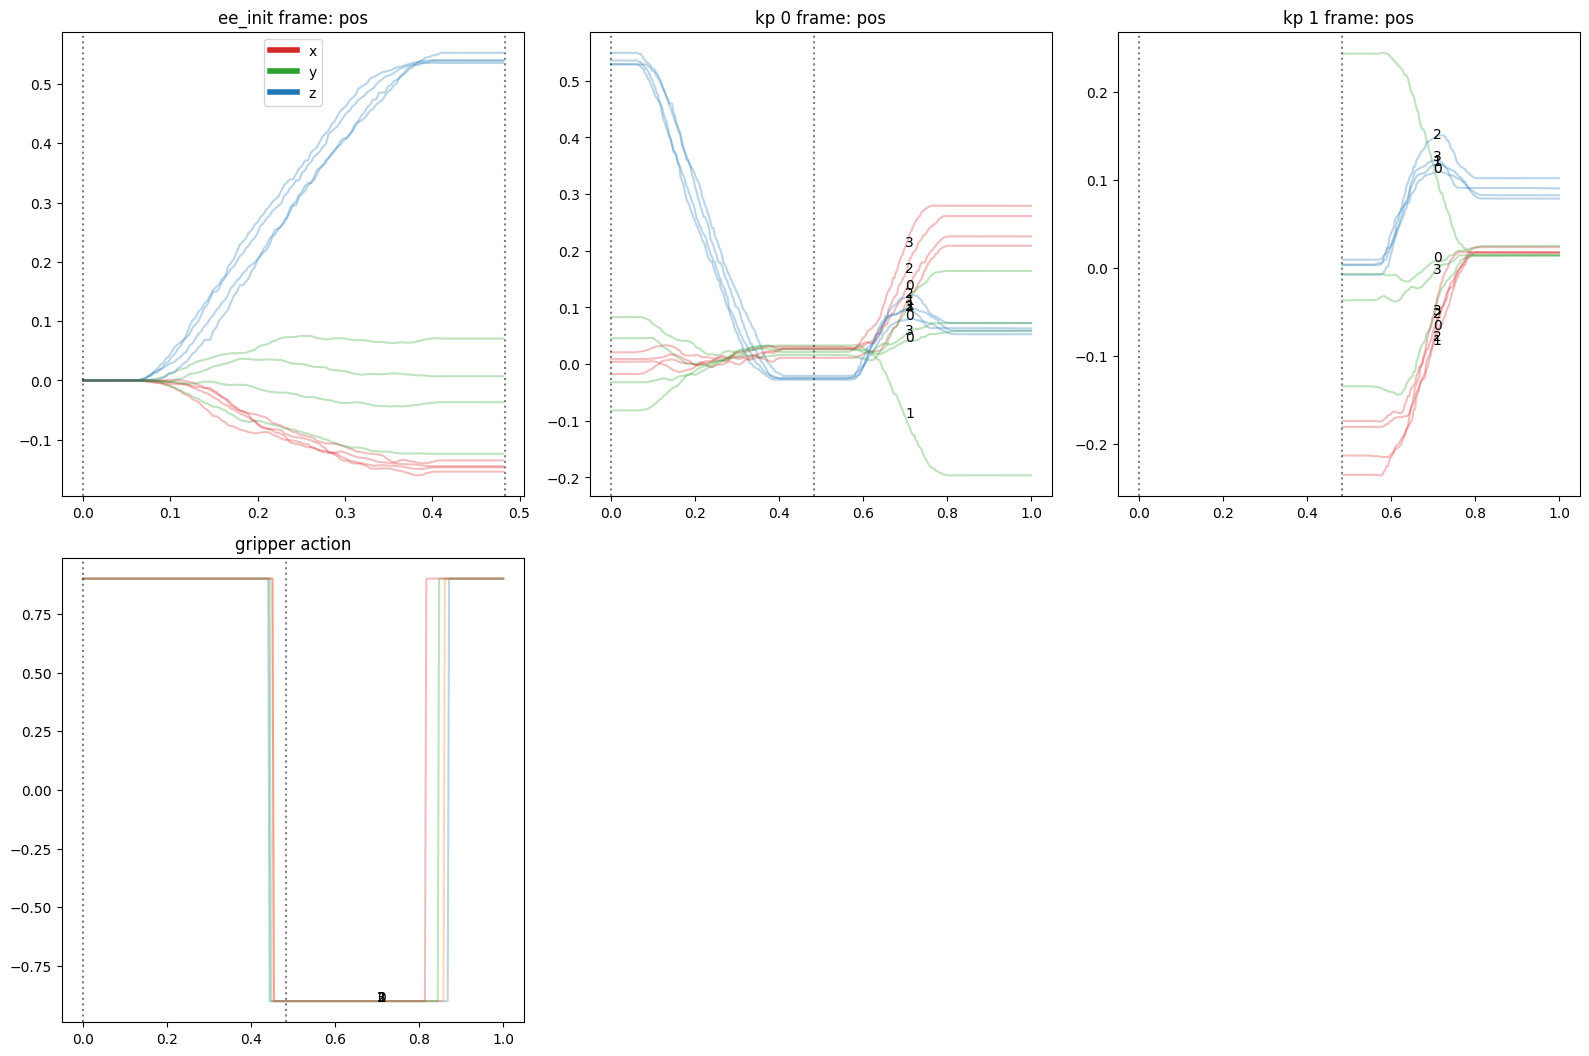

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-16 16:07:52.674 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:07:52.675 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:07:52.682 | INFO     |  HMM EM ...
2024-08-16 16:07:52.683 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-16 16:07:52.689 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-16 16:07:52.733 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [5.09e-007, 1.75e-006, 5.80e-006, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.31e-022, 7.57e-021, 1.24e-019, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [4.19e-244, 4.66e-244, 4.85e-244, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.14e-05, 2.48e-05, 5.35e-05, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [4.61e-37, 5.62e-35, 6.03e-33, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 8.69e-19, 1.35e-19, 2.07e-20],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.48e-04, 7.71e-05, 4.01e-05],
         [0.00e+00, 0.00e+00, 0.00e+00

2024-08-16 16:07:52.837 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-16 16:07:52.890 | WARNING  |  Skippig NaN Gaussians.


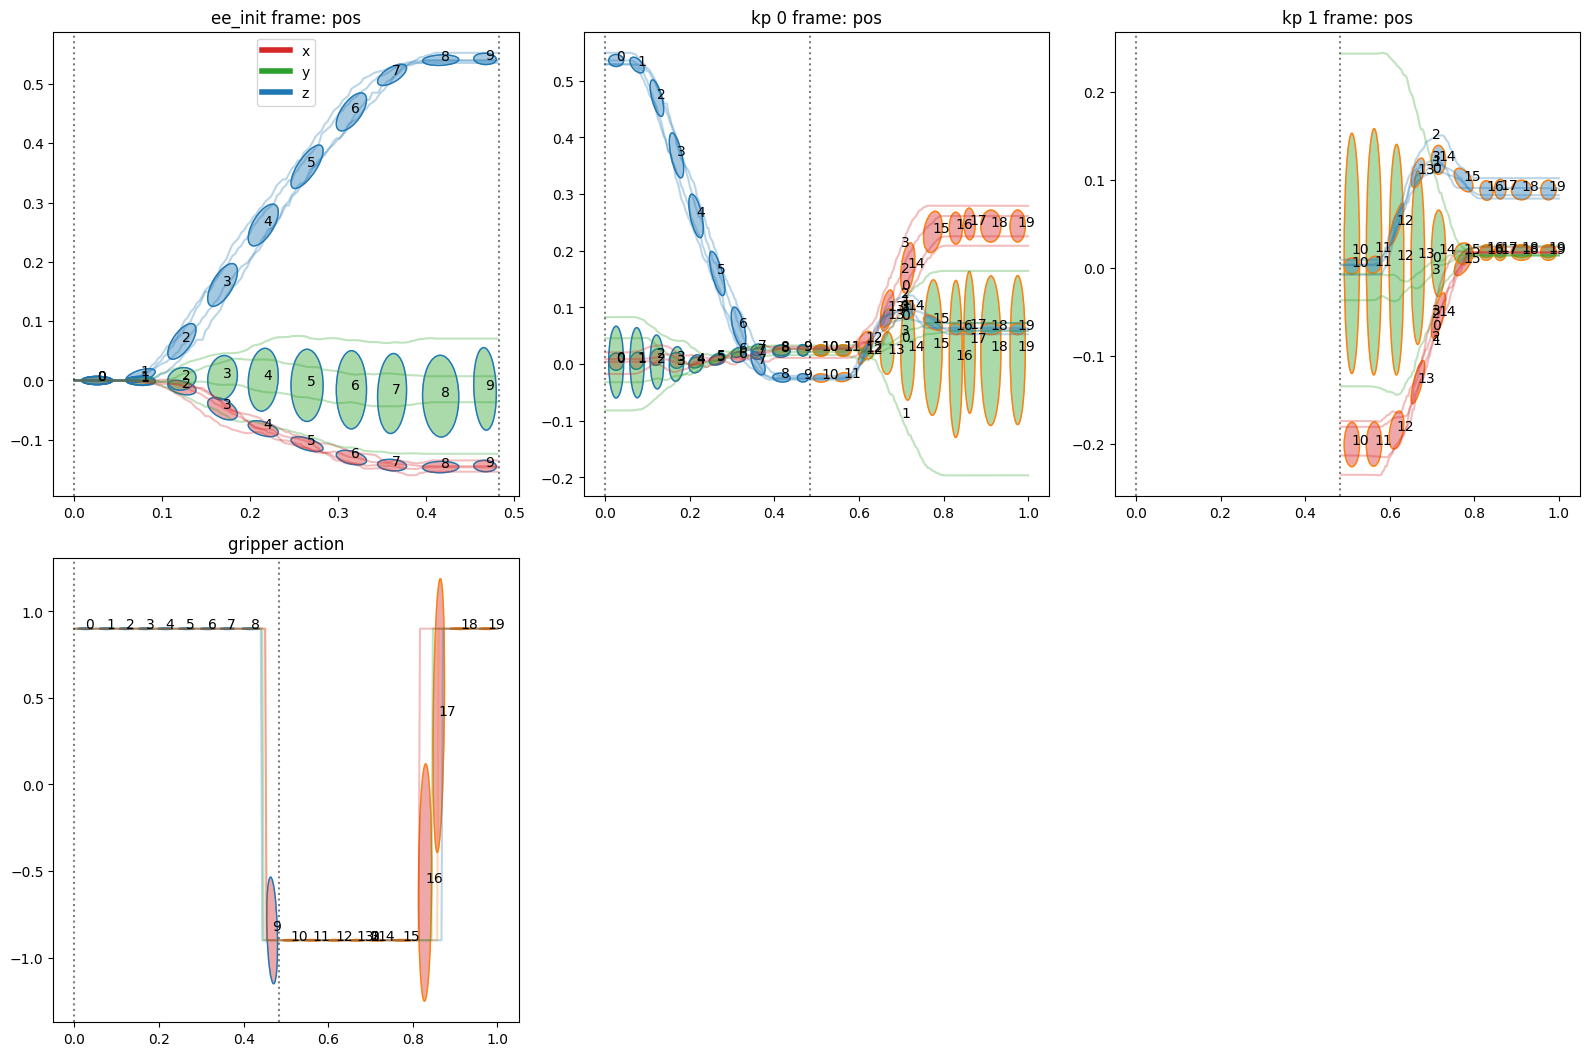

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-16 16:07:54.072 | INFO     |  Saving model:


2024-08-16 16:07:54.149 | INFO     |  Did not specify time_based, deciding automatically.


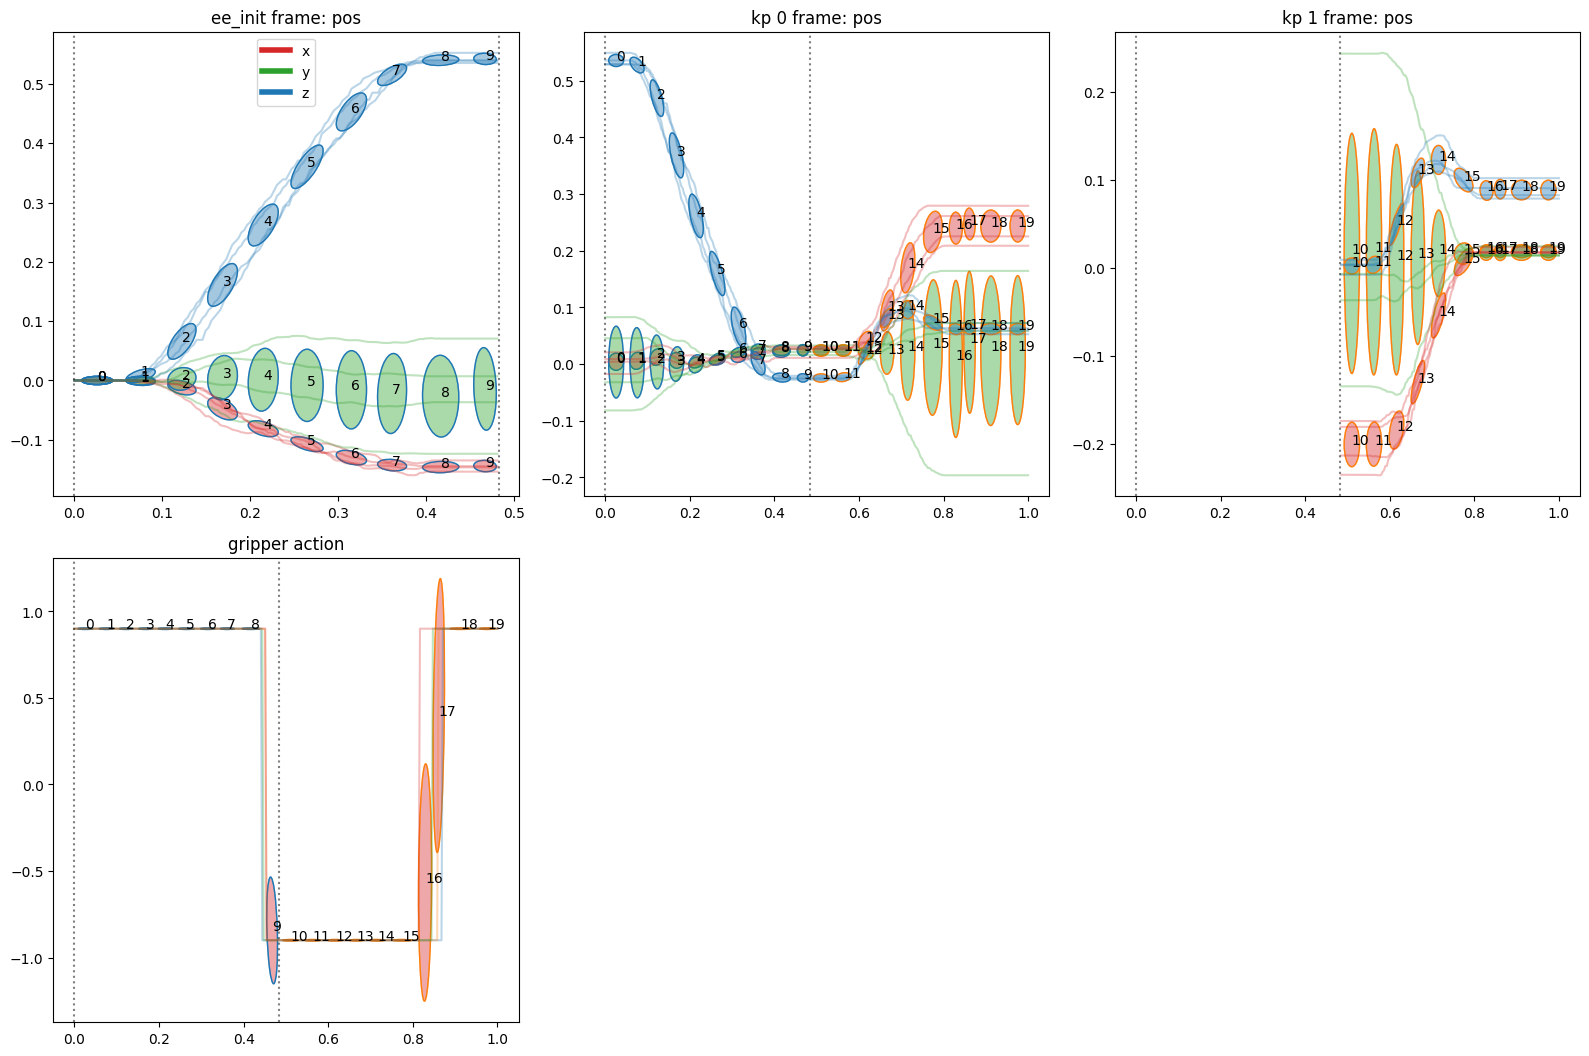

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


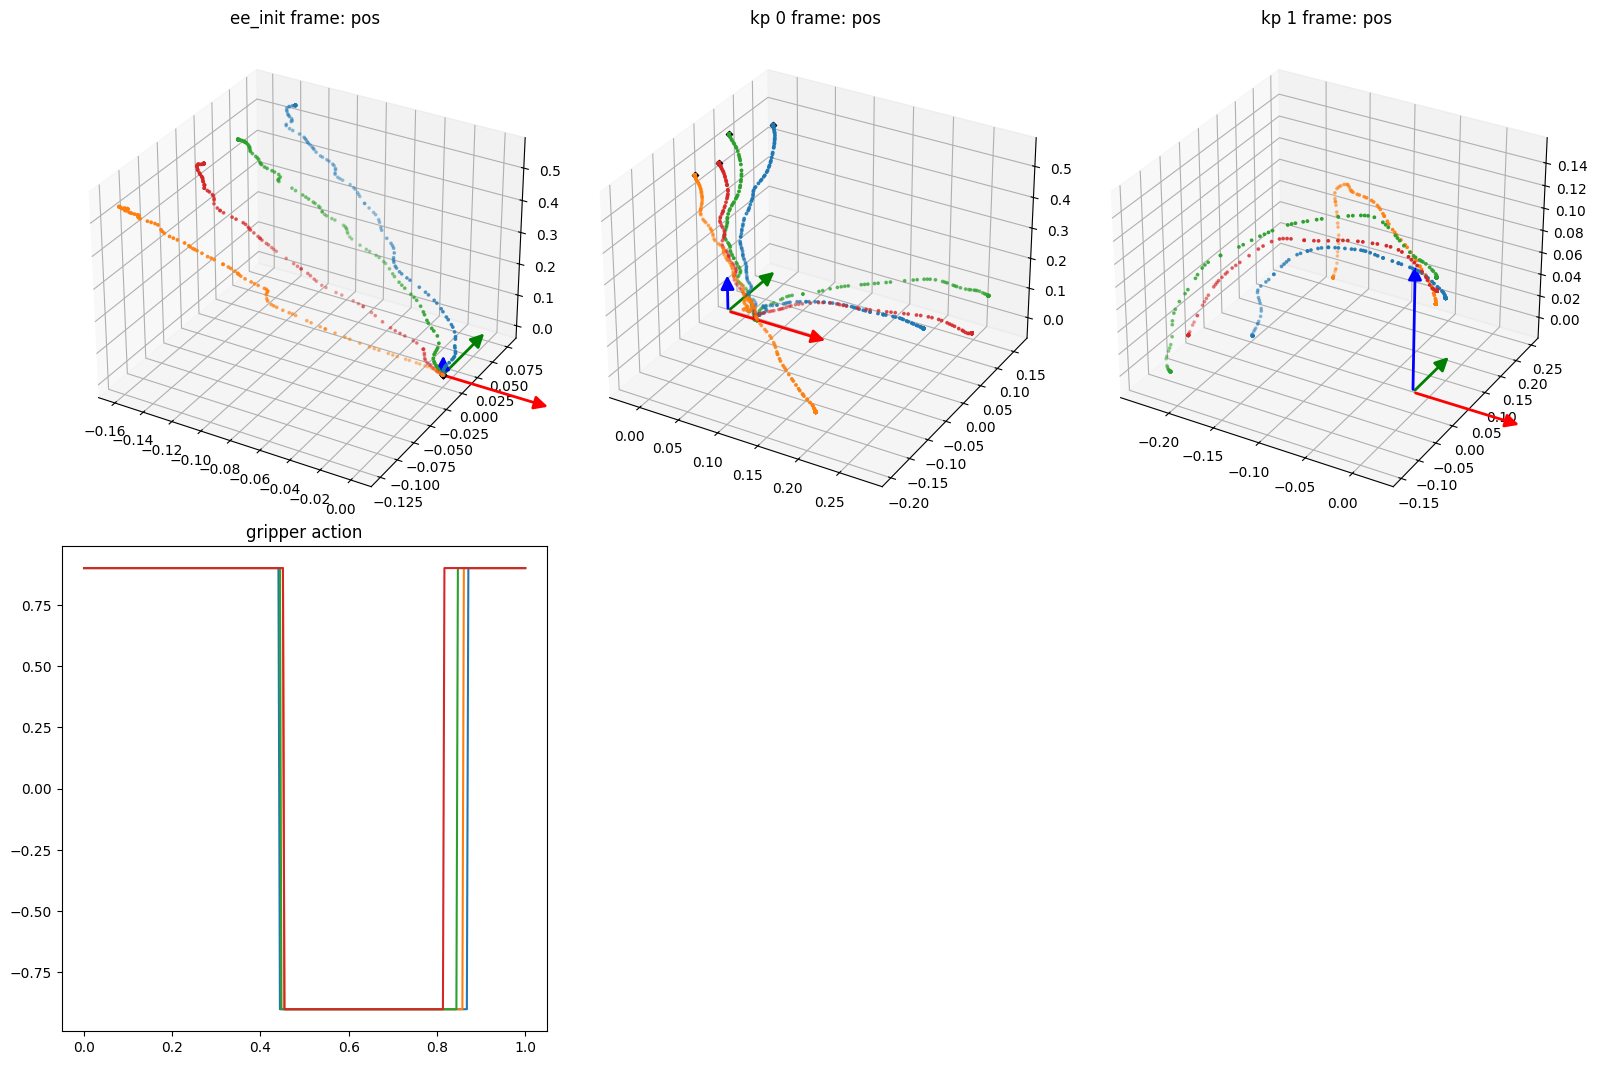

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-16 16:07:55.871 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-16 16:07:55.887 | INFO     |  Caculated segment transition probabilities: (array([[1.]]),)
2024-08-16 16:07:55.887 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:07:55.963 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:07:55.985 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:07:56.012 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

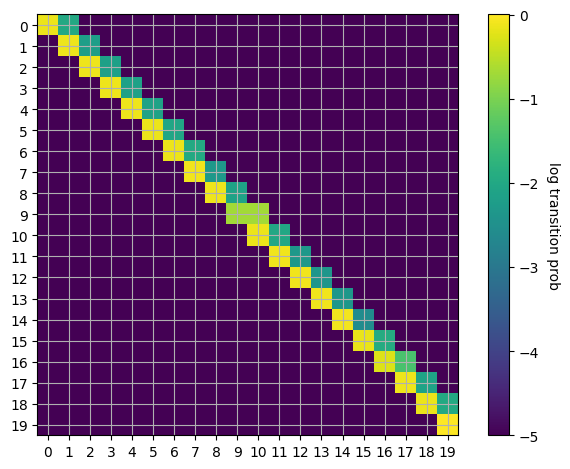

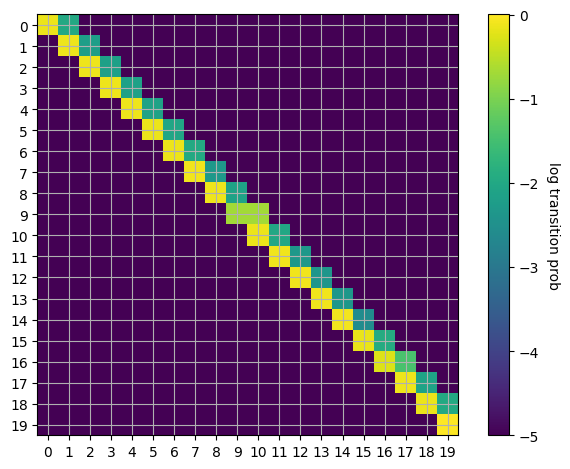

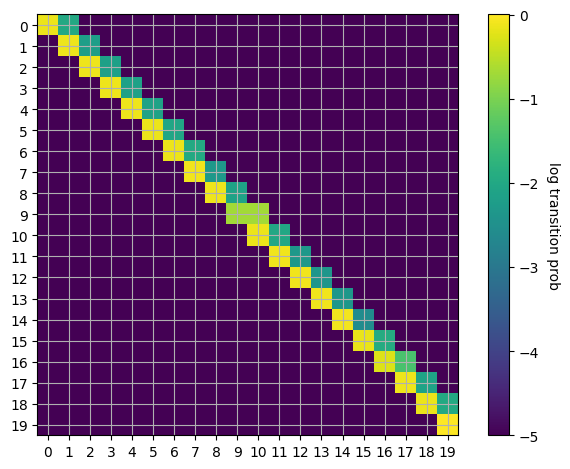

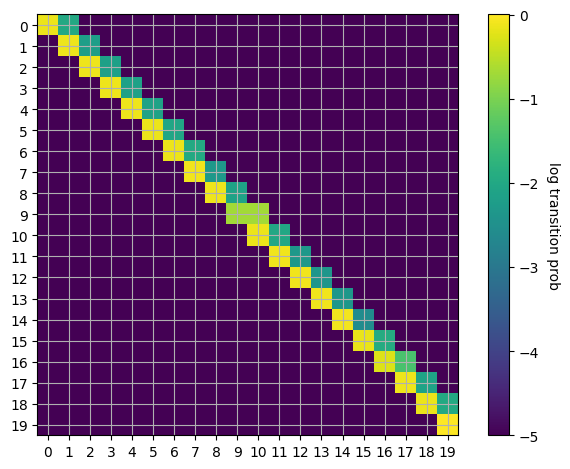

In [19]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-08-16 16:07:58.787 | INFO     |  Taking frame origins from demos.


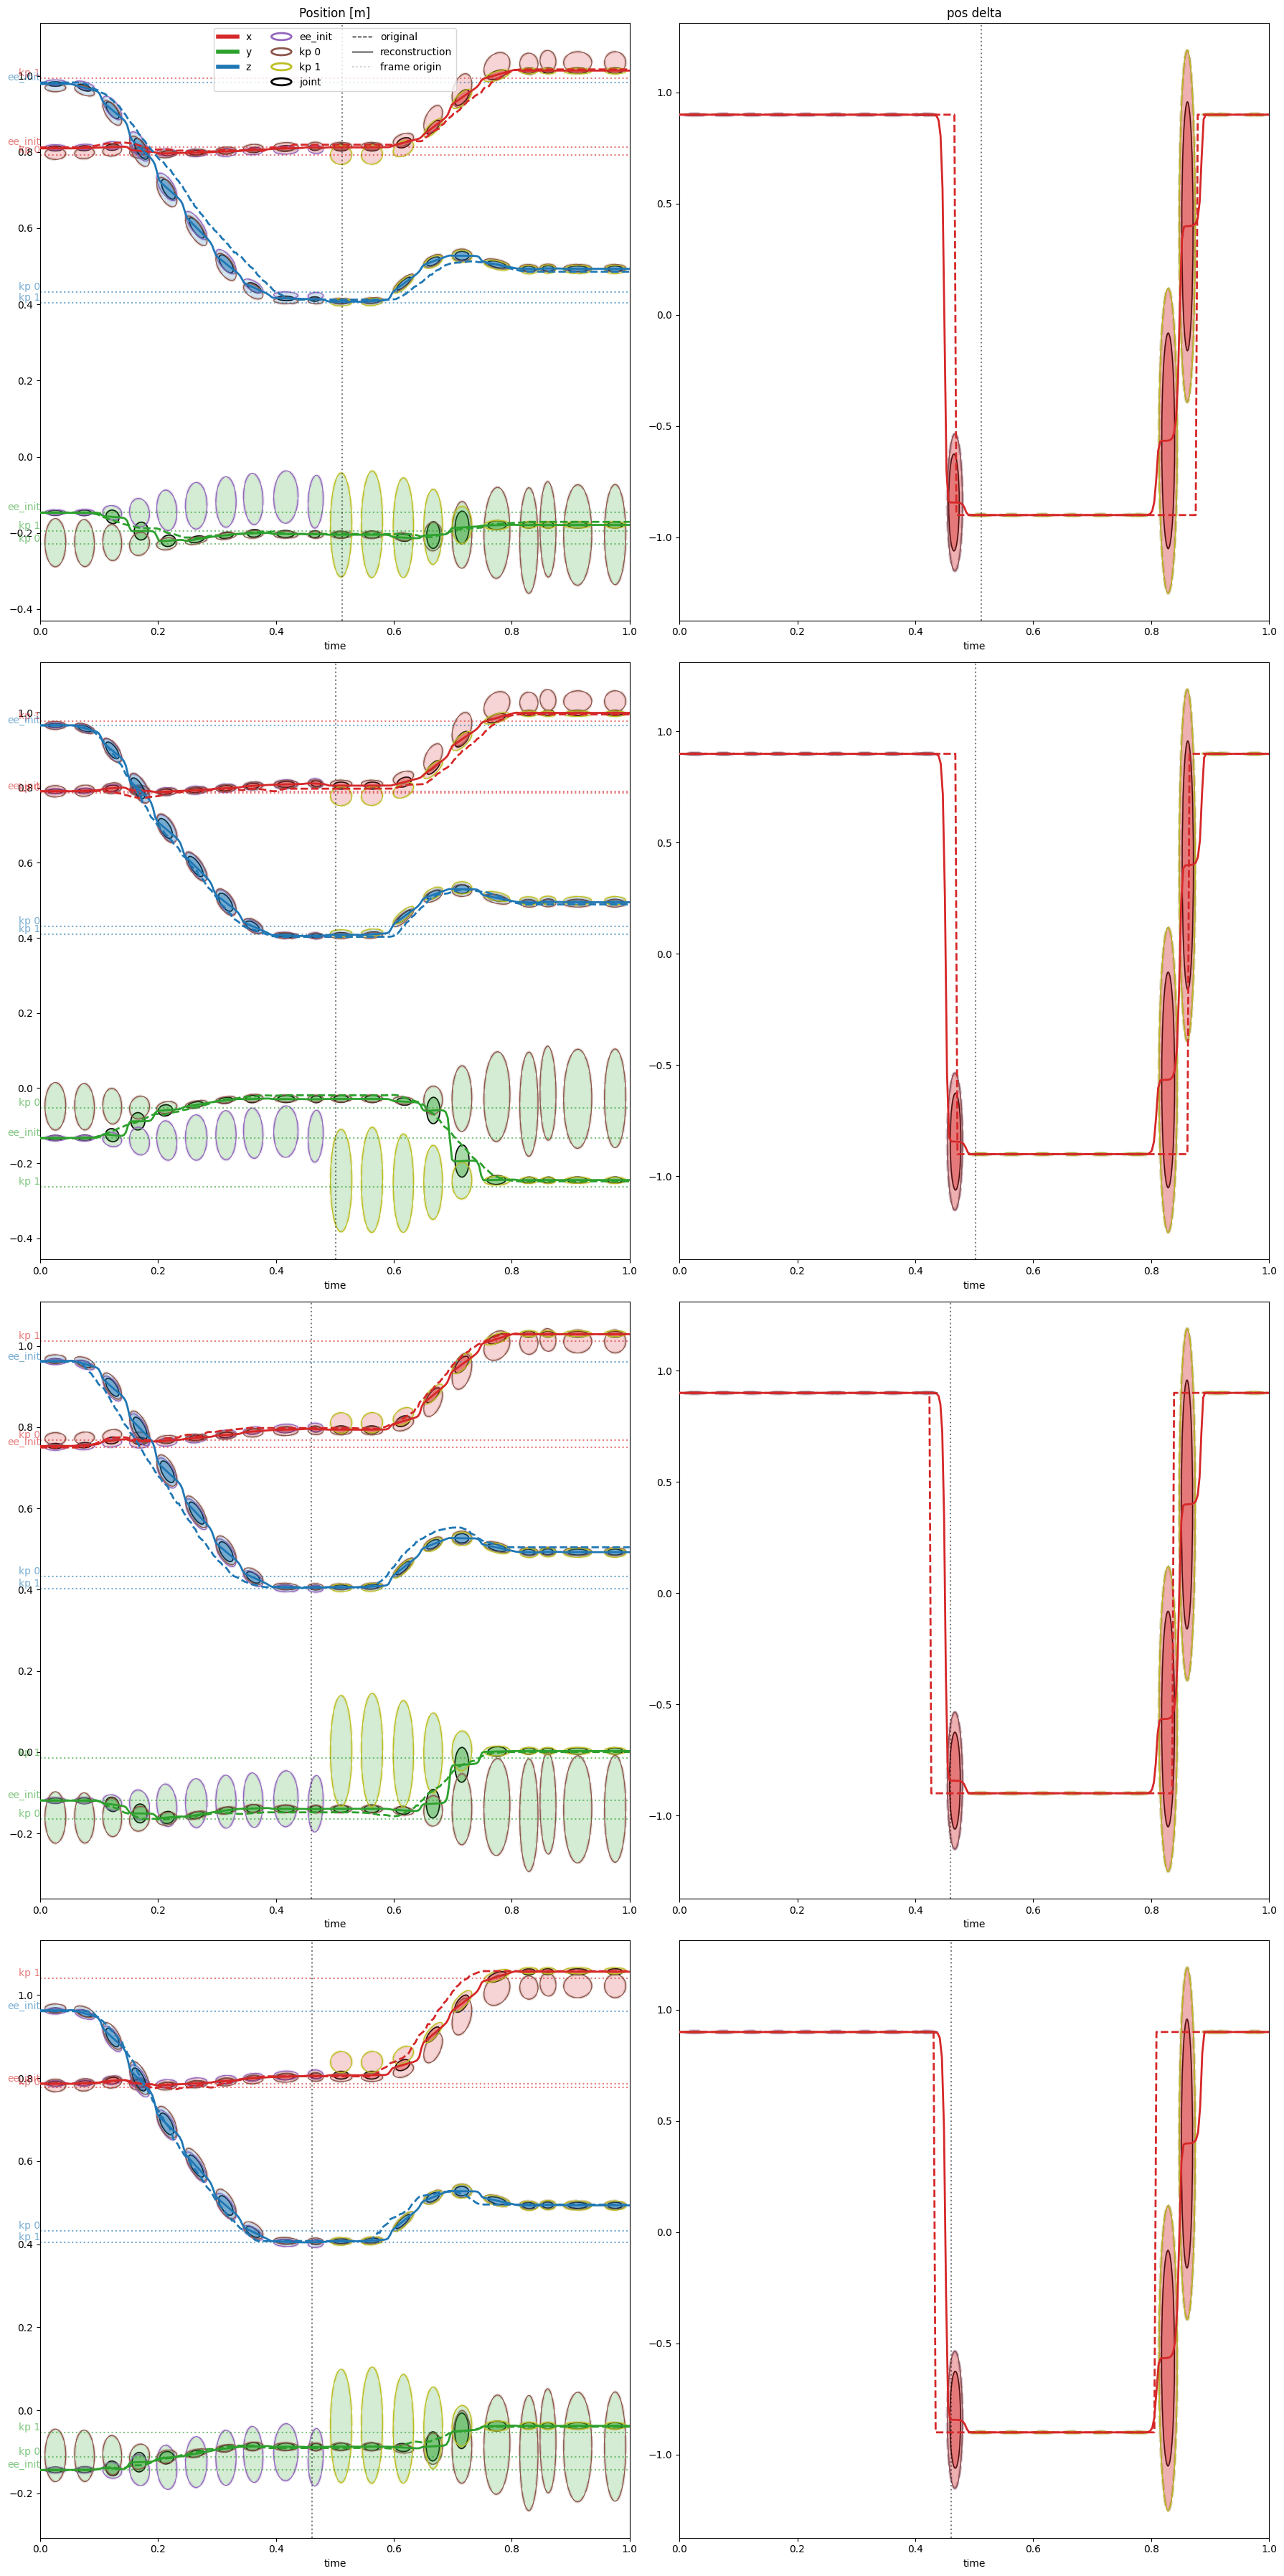

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


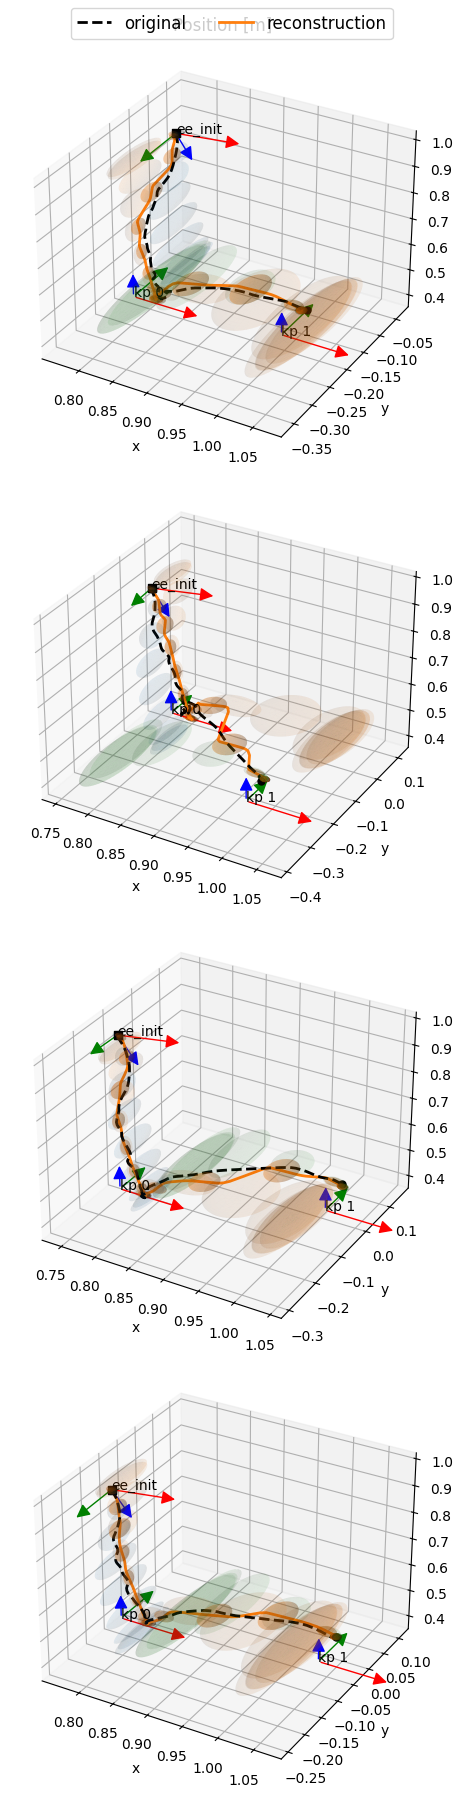

In [21]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)